In [2]:
import os, glob, re
import numpy as np
import pandas as pd

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
#make plots look nicer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import ks_2samp
#plot style throughout the file
#fontstyle
plt.rc("text", usetex = True)
plt.rc("font", family = "serif")

#fontsizes
plt.rc("font", size = 23)
plt.rc("axes", labelsize = 20)
plt.rc("xtick", labelsize =20)
plt.rc("ytick", labelsize = 20)
plt.rc("legend", fontsize = 18)

#tick format
plt.rc("xtick", top=False)
plt.rc("ytick", right=False)
plt.rc("xtick", direction="out")
plt.rc("ytick", direction="out")
plt.rc("xtick.major", size=5.0)
plt.rc("ytick.major", size=5.0)
plt.rc("xtick.major", width=1.0)
plt.rc("ytick.major", width=1.0)

#line format
plt.rc("lines", linewidth = 2)
plt.rc("lines", markersize = 6)
plt.rc("lines", markeredgewidth = 1)

from matplotlib.gridspec import GridSpec


In [18]:
# calculutes centered CAR
def car_series_all_days(R, window, mode= "centered"):
    return R.rolling(window=2 * window + 1, center= True).sum()

In [3]:
# gets adoption dates
def find_adoption(adopt_df,  anchor_ticker, date_col="annoucement_date", ticker_col="ticker"):
    t = anchor_ticker.upper()
    df = adopt_df.copy()
    df.columns =df.columns.str.strip()

    dummy = df.loc[df[ticker_col].astype(str).str.upper().eq(t)].copy()
    dummy["event_dt"] = pd.to_datetime(dummy[date_col]).dt.tz_localize(None)
    dummy = dummy.dropna(subset=["event_dt"])
    return sorted(dummy["event_dt"].dt.normalize().unique())

In [23]:
# log returns
def log_returns(path):
    df = pd.read_csv(path)
    price_col = "Close"

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.tz_localize(None)
    df = df.dropna(subset=["Date", price_col]).sort_values("Date")

    
    df["Date"] = df["Date"].dt.normalize()
    df = df.groupby("Date", as_index=False)[price_col].last()

    px = df.set_index("Date")[price_col].astype(float)
    return np.log(px).diff().dropna()

In [5]:
# calculates scores and returns rankings 
def ranking(df, obs_col="obs_mean_abs_CAR", p_col="p_perm"):
    out = df.copy()
    eps = 1e-12
    out["neglog10_p"] = -np.log10(out[p_col].clip(lower=eps))
    out["score_obs_p"] = out[obs_col] * out["neglog10_p"]
    return out.sort_values("score_obs_p", ascending=False)

In [6]:
def significance(scores, R, event_days, window, top_n=20, trials=2000, seed=0):

    rng = np.random.default_rng(seed)
    event_days = [d for d in event_days if d in R.index]
    m = len(event_days)

    # calculates CAR series for every ticker on every day
    car_all = R.rolling(window=2*window +1, center=True).sum()

    # only consider valid days where rolling window is defined
    valid_days = car_all.dropna(how="all").index
    event_days = [d for d in event_days if d in valid_days]

    # avoid sampling from null
    non_event_days = valid_days.difference(pd.Index(event_days))
    
    top = scores.copy() 

    # absolute CAR on event days for all tickers
    abs_car_event = car_all.loc[event_days].abs()  

    results = []
    for tkr in top.index:
        # mean absolute CAR on event days
        obs = float(abs_car_event[tkr].mean())

        # null distribution by random day sampling 
        null_vals = np.empty(trials, dtype=float)
        non_event_array = non_event_days.to_numpy()

        for i in range(trials):
            sampled_days = rng.choice(non_event_array, size=len(event_days), replace=False)
            null_vals[i] = float(car_all.loc[sampled_days, tkr].abs().mean())

        baseline = float(null_vals.mean())
        lift = (obs / baseline - 1.0) if baseline > 0 else np.nan

        # one-sided p-value
        p_perm = float((np.sum(null_vals >= obs) + 1) / (trials + 1))

        results.append((tkr, obs, baseline, lift,p_perm))

    res_df = pd.DataFrame(
        results,
        columns=["ticker", "obs_mean_abs_CAR", "baseline_mean_abs_CAR", "lift", "p_perm"]
    ).set_index("ticker")

    top = top.join(res_df, how="left")
    return top

In [20]:
def top_movers(ticker, adoption, folder, window: int = 3,  top_n: int = 20):

    ticker = ticker.upper()
    adopt = pd.read_csv(adoption)
    adopt.columns = adopt.columns.str.strip()
    event_dates = find_adoption(adopt, ticker)

    files = sorted(glob.glob(os.path.join(folder, "*.csv")))

    returns = {}
    for fp in files:
        ticker = os.path.splitext(os.path.basename(fp))[0].upper()
        returns[ticker] = log_returns(fp)

    R = pd.concat(returns, axis=1)
    R.columns = R.columns.get_level_values(0)
    R = R.sort_index()
    trading_days = R.index

    event_days = []
    for d in event_dates:
        d = pd.Timestamp(d).normalize()
        idx = trading_days.searchsorted(d, side="left")
        if idx < len(trading_days):
            event_days.append(trading_days[idx])
    event_days = sorted(pd.unique(event_days))

    cars = []
    for t0 in event_days:
        i0 = trading_days.get_loc(t0)
        lo = max(0, i0 - window)
        hi = min(len(trading_days) -1, i0 +window)
        cars.append(R.iloc[lo:hi + 1].sum(axis=0))

    CAR = pd.DataFrame(cars, index=event_days)

    scores = pd.DataFrame({
        "avg_abs_CAR": CAR.abs().mean(axis=0),
        "avg_CAR": CAR.mean(axis=0),
        "n_events_used": len(event_days),
        "n_events_with_data": CAR.notna().sum(axis=0),
    }).sort_values("avg_abs_CAR", ascending=False)

    top = significance(scores=scores, R=R,event_days=event_days, window=window, top_n=top_n, trials=2000, seed=0)
    top = ranking(top).head(top_n)


    if len(top.index) > 0:
        top_ticker = top.index[0]
        CAR_all = car_series_all_days(R, window=window)
        plot_func(CAR_all, top_ticker, event_days, window, anchor_ticker=ticker)

    return event_days, top, CAR





In [25]:
def plot_func(CAR_all, top_ticker, event_days, window, anchor_ticker):

    s = CAR_all[top_ticker].dropna()
    ev = [d for d in event_days if d in s.index]

    plt.figure()
    ax = plt.gca()

    # CAR time series
    ax.plot(s.index, s.values)

    y_top = np.nanmax(s.values) if len(s.values) else 0.0
    for i, d in enumerate(ev, start=1):
        ax.axvline(d, linestyle="--", linewidth=1)
        ax.scatter([d], [s.loc[d]])
        ax.annotate(
            d.strftime("%Y-%m-%d"),
            xy=(d, s.loc[d]),
            xytext=(0, 8),
            textcoords="offset points",
            ha="center",
            fontsize=8,
            rotation=90,
        )

    ax.set_title(f"{top_ticker} CAR over time (window={window})\nEvent dates from anchor: {anchor_ticker}")
    ax.set_xlabel("Date")
    ax.set_ylabel("CAR (sum of log returns over window)")
    plt.tight_layout()
    plt.show()

/var/folders/8s/rlbcmk_d5cg7v0tkl8ld_lhc0000gn/T/ipykernel_74115/534715903.py:26: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  event_days = sorted(pd.unique(event_days))


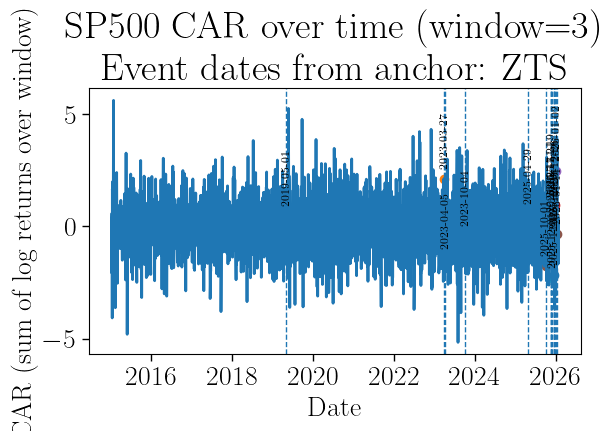

       avg_abs_CAR   avg_CAR  n_events_used  n_events_with_data  \
SP500     1.028669 -0.045334             18                  18   
LW        0.080400 -0.014592             18                  18   
ORCL      0.071458 -0.031220             18                  18   
MKC       0.051455  0.013464             18                  18   
INTC      0.072805  0.014026             18                  18   
MU        0.079204  0.034686             18                  18   
STX       0.067304  0.028242             18                  18   
HUM       0.061339 -0.004255             18                  18   
MRK       0.046795  0.044399             18                  18   
NOW       0.066172 -0.033031             18                  18   
J         0.047756 -0.012199             18                  18   
IRM       0.048865 -0.003410             18                  18   
NKE       0.050569 -0.004434             18                  18   
REGN      0.048945  0.031875             18                  1

In [26]:
events_used, top_movers, car_matrix = top_movers(ticker="META",
    adoption="/Users/valenciazhang/Downloads/final_model_data.csv",
    folder="/Users/valenciazhang/Downloads/cit-datathon-main/data/raw",
    window=3,
    top_n=20
)

print(top_movers)

